Pneumonia - ML in healthcare - Data Exploration + CNN Training
===
Inspiration from:

*  Kaggle Pneumonia colab: https://www.kaggle.com/code/madz2000/pneumonia-detection-using-cnn-92-6-accuracy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

In [3]:
# from scipy.stats import norm
# from sklearn.preprocessing import StandardScaler
# from scipy import stats
# import warnings
# warnings.filterwarnings('ignore')
%matplotlib inline
import torch
import torch.nn.functional as F
# import param

In [5]:
# import sklearn as sk
# import scipy
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc


# , precision_score, recall_score, auc, roc_curve, roc_auc_score, accuracy_score, classification_report 

In [6]:
import param
import panel as pn
pn.extension()
import datetime as dt
import importlib
from importlib import reload
from tqdm import tqdm

In [ ]:
import cv2

In [7]:
import graph as gr
import params as par
import py_lib as lib
reload(gr)
reload(par)
reload(lib)
import graph as gr
import params as par
import py_lib as lib

In [8]:
format_dict = par.create_format_dict()
format_dict

{'Age': '{:.0f}',
 'RestingBP': '{:.0f}',
 'Cholesterol': '{:.0f}',
 'MaxHR': '{:.0f}',
 'FastingBS': '{:.1f}',
 'HeartDisease': '{:.1f}',
 'Oldpeak': '{:.2f}',
 'Accuracy': '{:.1%}',
 'Balanced Accuracy': '{:.1%}',
 'F1 Score': '{:.1%}'}

In [9]:
class NotebookParams(param.Parameterized):
    lambda_multiple          = param.Number(1, bounds=(1,10), doc="lambda Lasso Multiple of 10^x")
    lambda_power             = param.Integer(default=2, bounds=(1,7),doc="lambda Lasso exponent of 10^x")
    lr_multiple              = param.Number(5, bounds=(1,10), doc="Learning Rate Multiple of 10^x")
    lr_power                 = param.Integer(default=3, bounds=(1,9),doc="Learning Rate exponent of 10^x")
    epochs                   = param.Integer(default=12 ,bounds=(1,2000))
    data_set                 = param.ObjectSelector(default="test",objects=['train', 'validation', 'train + validation', 'test'])
    stand_features           = param.Boolean(True, doc="Whether we want to standardize numerical features")
    use_lasso                = param.Boolean(True)
    use_focal_loss           = param.Boolean(True)
    iter_array               = param.Integer(default=5, bounds=(1,20),doc="How often to save loss and training data, in epochs")
    iter_printing            = param.Integer(default=5, bounds=(1,100),doc="How many epochs between printing")
    add_one_hot_encoded      = param.Boolean(True, doc="Whether to add one hot encoded columns from categorical variables")
    test_size                = param.Number(0.2, bounds=(0.1,0.9), doc="Test size for train_test_split")
    random_state_test_train_split = param.Integer(42)

base = NotebookParams()

# Import Data

In [1]:
# # Input data files are available in the "../input/" directory.
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('../../../untracked_data/chest_data/chest_xray'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [13]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
train = lib.get_training_data(
    '../../../untracked_data/chest_data/chest_xray/train',
		img_size=img_size,
		labels=labels,
        )
test = lib.get_training_data(
    '../../../untracked_data/chest_data/chest_xray/test',
		img_size=img_size,
		labels=labels,
        )

OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



# Data Visualization & Preprocessing

<Axes: xlabel='count'>

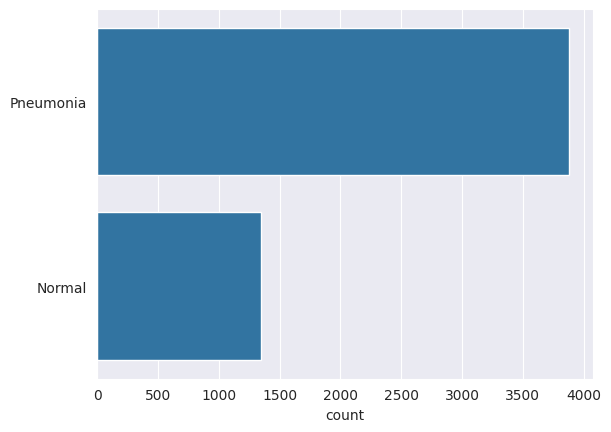

In [14]:
list_all_labels = []
for i in train:
    if(i[1] == 0):
        list_all_labels.append("Pneumonia")
    else:
        list_all_labels.append("Normal")
sns.set_style('darkgrid')
sns.countplot(list_all_labels) 

In [17]:
import random

In [18]:
count_labels = pd.Series(list_all_labels).value_counts()
index_pneumonia = [i for i, n in enumerate(list_all_labels) if n == 'Pneumonia']
index_normal = [i for i, n in enumerate(list_all_labels) if n == 'Normal']
index_outcomes = {
		'Pneumonia': index_pneumonia,
		'Normal': index_normal,
}
for col_idx, outcome in enumerate(list(set(list_all_labels))):
		n_imgs = count_labels[outcome]
		items_to_plot = random.sample(range(0,n_imgs), 3)

items_to_plot are [676, 1051, 2682, 1858, 558, 534]
items_to_plot are [469, 1293, 924, 496, 50, 894]


/home/pinolej/eth/healthcare/chest/graph.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


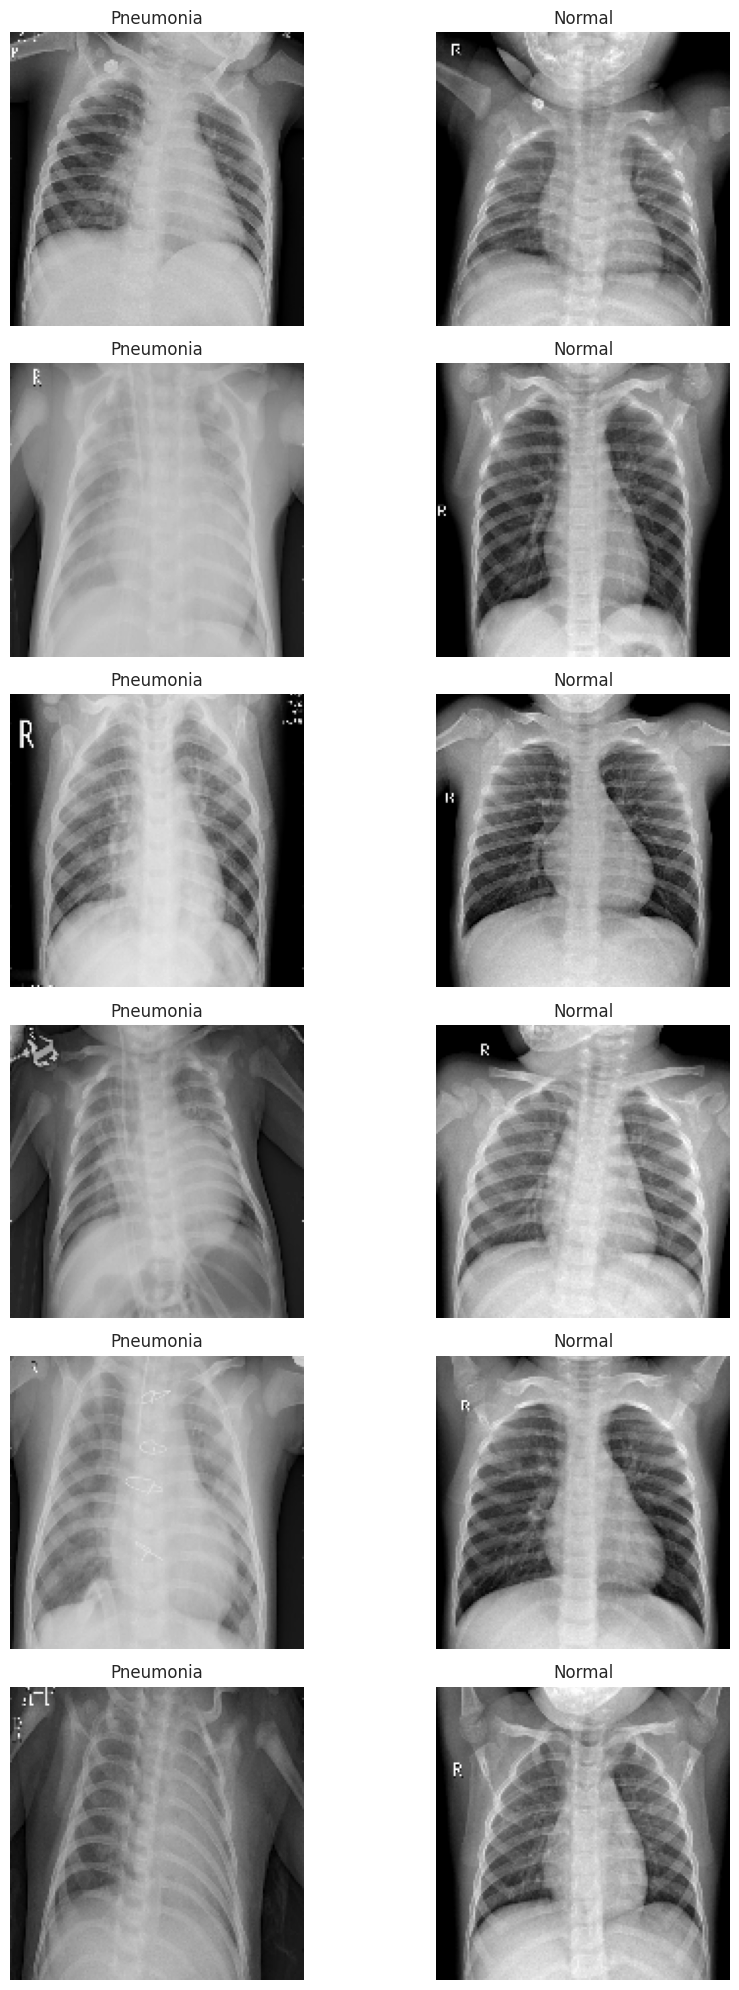

In [24]:
gr.images_subplots(
    img_data=train,
    ncols=2,
		nrows=6,
		figsize=(10,20),
		list_all_labels=list_all_labels,
    labels=list(set(list_all_labels)),
)

# CNN

In [30]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

## Features Preprocessing

In [31]:
pn.Column(pn.Row(base.param.test_size))

BokehModel(combine_events=True, render_bundle={'docs_json': {'07d065c8-d308-41d5-b538-f1a12fa1c0b6': {'version…

In [32]:
# Split train into train and val
n_train_initial = len(train)
n_test = math.ceil(base.test_size * n_train_initial)
idx_for_test_elements = random.sample(range(0,n_train_initial), n_test)
train_train = [train[i] for i in range(n_train_initial) if i not in idx_for_test_elements]
train_val = [train[i] for i in range(n_train_initial) if i in idx_for_test_elements]

In [33]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train_train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in train_val:
    x_val.append(feature)
    y_val.append(label)

In [34]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [35]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [36]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [37]:
import py_lib as lib
reload(lib)
import py_lib as lib

## Working with the class imbalance

In [35]:
# # From ... https://saturncloud.io/blog/how-to-use-class-weights-with-focal-loss-in-pytorch-for-imbalanced-multiclass-classification/#focal-loss
# class_counts = np.bincount(y_train)
# num_classes = len(class_counts)
# total_samples = len(y_train)

# class_weights = []
# for count in class_counts:
#     weight = 1 / (count / total_samples)
#     class_weights.append(weight)

# class_weights_tensor = torch.FloatTensor(class_weights)

In [36]:
# class_weights

## Model Building

In [121]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

/home/pinolej/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

## Training

In [123]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [127]:
history = model.fit(
	datagen.flow(
		x_train,
		y_train,
		batch_size = 32,
	) ,
	epochs = 12 ,
	validation_data = datagen.flow(x_val, y_val),
	callbacks = [learning_rate_reduction],
	verbose=0,
	)

/home/pinolej/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 7: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.

Epoch 12: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.


In [25]:
# equivalent to: model.save("model.h5")
from tensorflow.keras.models import save_model
# save_model(model, "model_second_save.h5")
# save model and architecture to single file
model.save("cnn_v0.h5")
model.save('cnn_v0.keras')
print("Saved model to disk")


2024-04-15 00:06:06.977895: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-15 00:06:07.869636: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 00:06:10.730635: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


NameError: name 'model' is not defined

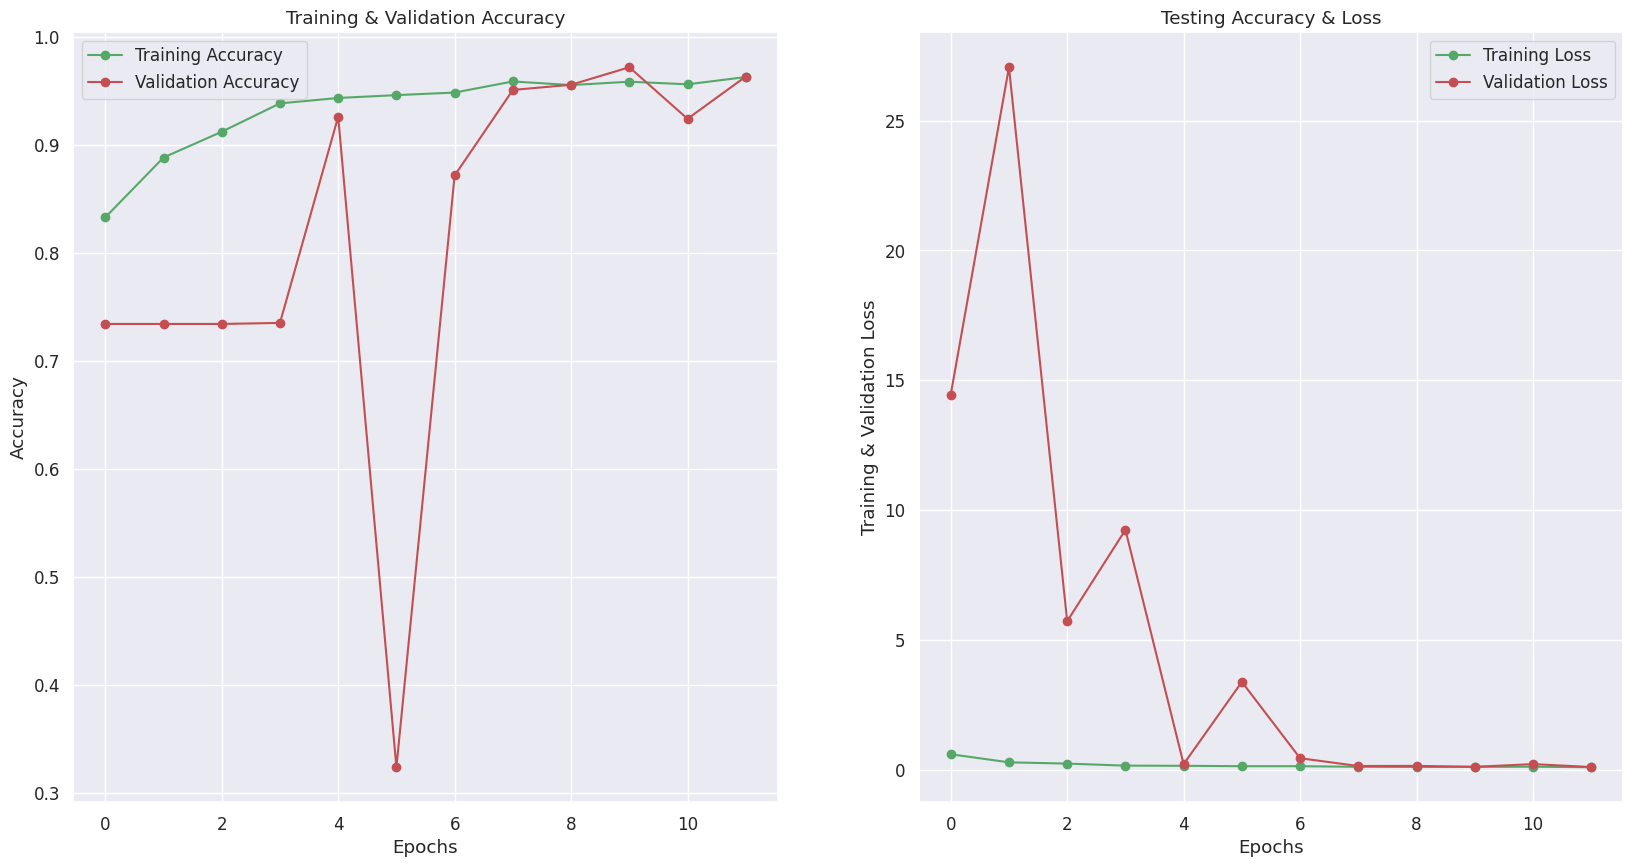

In [160]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

# Load model

In [26]:
# load model
from keras import models
model = models.load_model('cnn_v0.h5')

# Evaluation

<Axes: xlabel='count'>

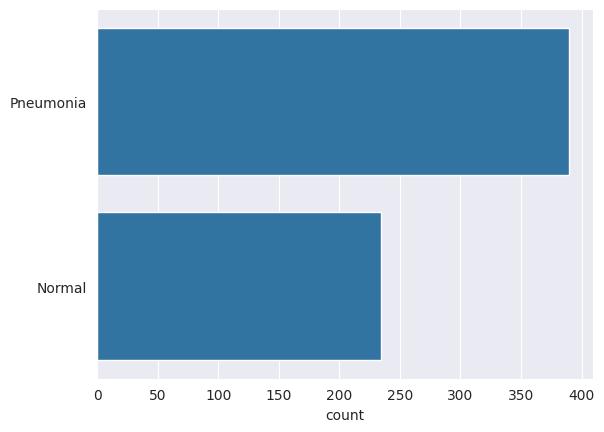

In [27]:
list_all_labels_test = []
for i in test:
    if(i[1] == 0):
        list_all_labels_test.append("Pneumonia")
    else:
        list_all_labels_test.append("Normal")
sns.set_style('darkgrid')
sns.countplot(list_all_labels_test) 

In [38]:
results = model.evaluate(x_test, y_test, batch_size=32, verbose=0)
print("Loss of the model is - " , results[0])
print("Accuracy of the model is - " , results[1]*100 , "%")

Loss of the model is -  0.2990112900733948
Accuracy of the model is -  87.5 %


In [39]:
print("test loss, test acc:", results)

test loss, test acc: [0.2990112900733948, 0.875]


## Predictions performances

In [40]:
# Generate a prediction using model.predict() 
# and calculate it's shape:
print("Generate a prediction")
predictions_proba = model.predict(x_test)

Generate a prediction


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 251ms/step


In [107]:
predictions = np.copy(predictions_proba)
predictions[predictions <= 0.5] = 0.
predictions[predictions > 0.5] = 1.

<Axes: >

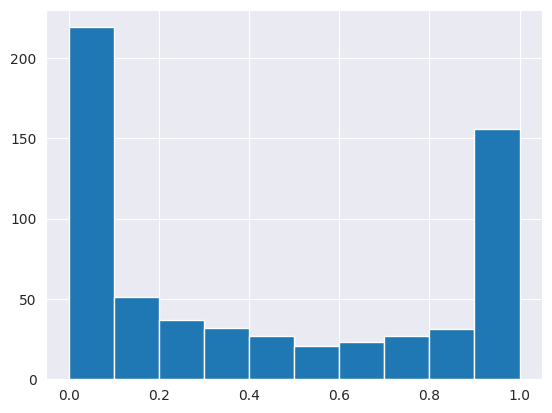

In [41]:
pd.Series(data=predictions_proba.flatten(), name='probability of xray being normal').hist()

<Axes: >

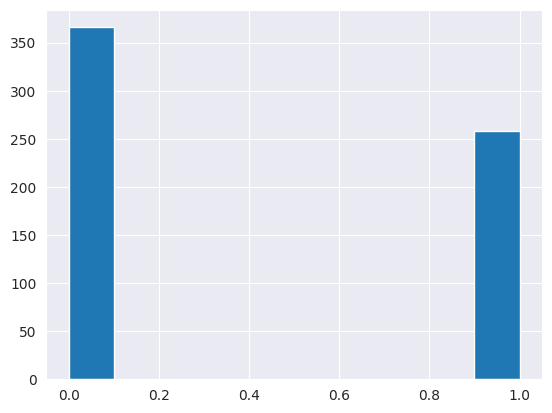

In [46]:
pd.Series(data=predictions.flatten(), name='predicted_classes').hist()

In [47]:
cm = confusion_matrix(y_test,predictions)
cm

array([[339,  51],
       [ 27, 207]])

In [48]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

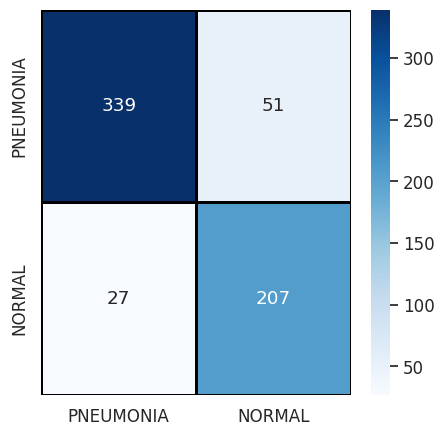

In [175]:
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [182]:
y_true = torch.from_numpy(y_test)
y_pred_round = predictions.flatten()
y_pred_round_tensor = torch.from_numpy(predictions).flatten()
y_pred = predictions_proba

In [185]:
from torchmetrics.classification import BinaryF1Score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
acc = accuracy_score(y_true, y_pred_round, normalize = True)  
bal_acc=balanced_accuracy_score(y_true,y_pred_round)
f1_score = BinaryF1Score()
f1 = f1_score(y_pred_round_tensor, y_true).numpy()
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [ ]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,87.5%,87.7%,84.1%


<style type="text/css">
</style>
<table id="T_4e833">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_4e833_level0_col0" class="col_heading level0 col0" >Accuracy</th>
      <th id="T_4e833_level0_col1" class="col_heading level0 col1" >Balanced Accuracy</th>
      <th id="T_4e833_level0_col2" class="col_heading level0 col2" >F1 Score</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_4e833_level0_row0" class="row_heading level0 row0" >metrics</th>
      <td id="T_4e833_row0_col0" class="data row0 col0" >87.5%</td>
      <td id="T_4e833_row0_col1" class="data row0 col1" >87.7%</td>
      <td id="T_4e833_row0_col2" class="data row0 col2" >84.1%</td>
    </tr>
  </tbody>
</table>


In [ ]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,87.5%,87.7%,84.1%


Text(0.5, 1.0, 'Confusion Matrix Pneumonia Prediction - CNN')

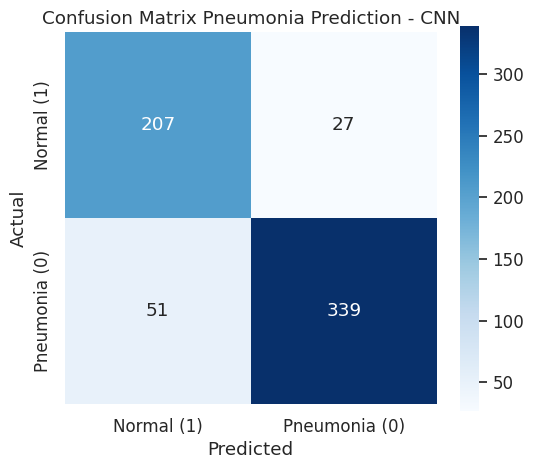

In [217]:
logreg_conf_matrix = confusion_matrix(y_true, y_pred_round)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['Pneumonia (0)', 'Normal (1)'],
    yticklabels=['Pneumonia (0)', 'Normal (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix Pneumonia Prediction - CNN')

In [188]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc_performance = auc(fpr, tpr)

/home/pinolej/eth/healthcare/chest/graph.py:116: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)
/home/pinolej/eth/healthcare/chest/graph.py:118: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)


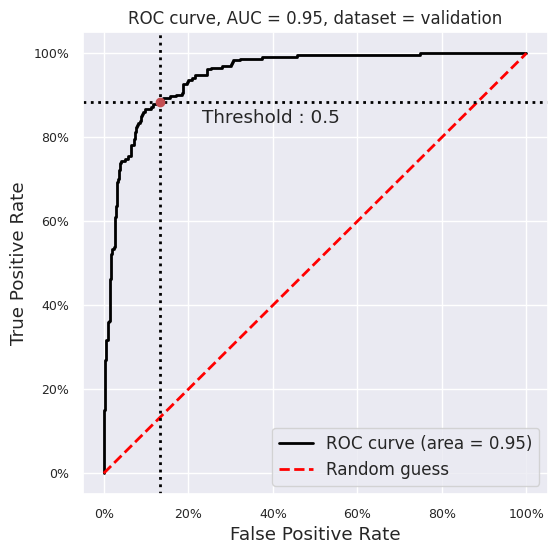

In [189]:
gr.custom_roc_curve(
        fpr,
        tpr,
        thresholds,
        thresholds_to_plot=[0.5],
        figsize=(6,6),
        fontsize={
            'ax_title': 12,
        },
        dataset_type=base.data_set,
        auc_performance=auc_performance,
        y_text_margin=0.05,
        x_text_margin=0.1,
        plot_threshold=True,
)

## Display correct and incorrect examples

Some of the Correctly Predicted Classes

In [ ]:
correct = np.nonzero(predictions.flatten() == y_test)[0]
incorrect = np.nonzero(predictions.flatten() != y_test)[0]

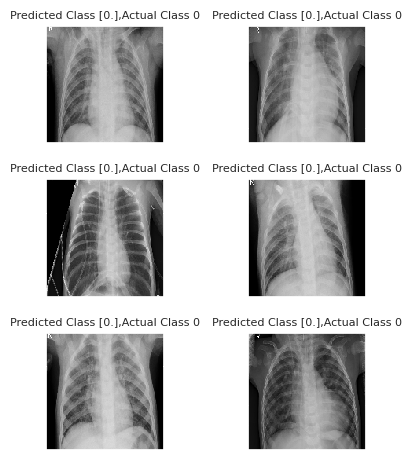

In [215]:
i = 0
# TODO(pinolej): use fig, axs = plt.subplots(2, 2, figsize=(15, 15)) to increase figsize
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]), fontsize=8)
    plt.tight_layout()
    i += 1

Some of the Incorrectly Predicted Classes

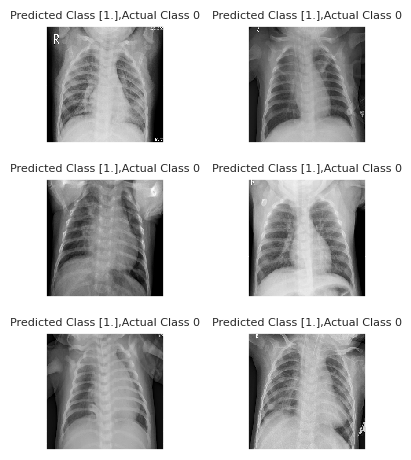

In [213]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]), fontsize=8)
    plt.tight_layout()
    i += 1

# Integrated Gradients

[New] Inspired from:

*  https://www.tensorflow.org/tutorials/interpretability/integrated_gradients

[Old] Inspired from:

*  Main repository: https://github.com/ankurtaly/Integrated-Gradients/tree/master
*  ig_inception notebook: https://github.com/ankurtaly/Integrated-Gradients/blob/master/ig_inception.ipynb


In [46]:
import tensorflow as tf
# import tensorflow_hub as hub

In [ ]:
model_example = tf.keras.Sequential([
    hub.KerasLayer(
        name='inception_v1',
        handle='https://tfhub.dev/google/imagenet/inception_v1/classification/4',
        trainable=False),
])
model_example.build([None, 224, 224, 3])
model_example.summary()

In [49]:
def load_imagenet_labels(file_path):
  labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)
  with open(labels_file) as reader:
    f = reader.read()
    labels = f.splitlines()
  return np.array(labels)

In [52]:
imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

In [53]:
def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
  return image

In [54]:
img_url = {
    'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
    'Giant Panda': 'http://storage.googleapis.com/download.tensorflow.org/example_images/Giant_Panda_2.jpeg',
}

img_paths = {name: tf.keras.utils.get_file(name, url) for (name, url) in img_url.items()}
img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_paths.items()}

## On my use case

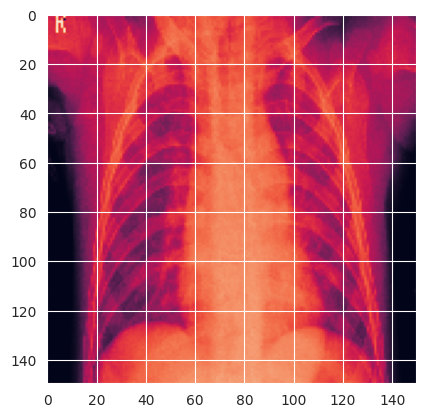

In [47]:
plt.imshow(test[0][0])
plt.show()

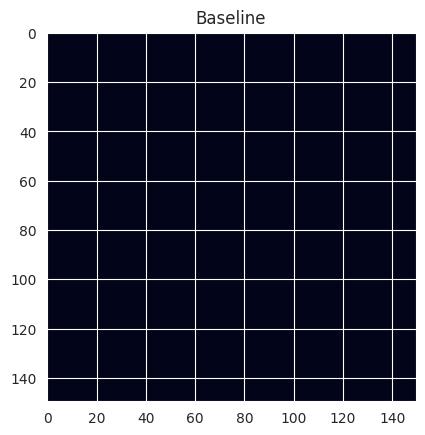

In [48]:
# baseline = tf.zeros(shape=(150,150), dtype=tf.uint8)
baseline = tf.zeros(shape=(150,150))
plt.imshow(baseline)
plt.title("Baseline")
# plt.axis('off')
plt.show()

In [99]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.

In [53]:
def interpolate_images(
		baseline,
		image,
		alphas,
    ):
	alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
	baseline_x = tf.expand_dims(baseline, axis=0)
	input_x = tf.expand_dims(image, axis=0)
	input_x = tf.cast(
    input_x, tf.float32
)
	delta = input_x - baseline_x
	images = baseline_x +  alphas_x * delta
	return images

In [60]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.

In [61]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=test[0][0],
    alphas=alphas)

In [88]:
def compute_gradients(
		images,
		alpha_length=32,
		target_is_class_zero=False,
		):
	print(images.shape)
	with tf.GradientTape() as tape:
		tape.watch(images)
		# probs = model.predict(tf.reshape(images, [alpha_length, 150, 150, 1])) # Proba of the class... which one? 1 = normal?
		probs = model(tf.reshape(images, [alpha_length, 150, 150, 1])) # Proba of the class... which one? 1 = normal?
		if target_is_class_zero:
			probs = 1 - probs
		# probs_tensor = tf.convert_to_tensor(probs)
	return tape.gradient(probs, images)
	# return probs

In [89]:
path_gradients = compute_gradients(
    images=interpolated_images,
		alpha_length=51)

(51, 1, 150, 150)


In [82]:
path_gradients

In [86]:
model.predict(tf.reshape(interpolated_images, [51, 150, 150, 1]))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


array([[1.10727080e-15],
       [9.70058560e-01],
       [2.29040101e-01],
       [2.68756738e-03],
       [2.40059690e-05],
       [2.10113441e-07],
       [1.79571402e-09],
       [1.55626623e-11],
       [1.38199673e-13],
       [1.27119317e-15],
       [1.18705265e-17],
       [1.11096224e-19],
       [1.04219527e-21],
       [9.81990858e-24],
       [9.25998580e-26],
       [8.74212246e-28],
       [8.25611862e-30],
       [7.79261125e-32],
       [7.35535147e-34],
       [6.93680281e-36],
       [6.54586646e-38],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],


In [83]:
probs_tensor

<tf.Tensor: shape=(51, 1), dtype=float32, numpy=
array([[1.10727080e-15],
       [9.70058560e-01],
       [2.29040101e-01],
       [2.68756738e-03],
       [2.40059690e-05],
       [2.10113441e-07],
       [1.79571402e-09],
       [1.55626623e-11],
       [1.38199673e-13],
       [1.27119317e-15],
       [1.18705265e-17],
       [1.11096224e-19],
       [1.04219527e-21],
       [9.81990858e-24],
       [9.25998580e-26],
       [8.74212246e-28],
       [8.25611862e-30],
       [7.79261125e-32],
       [7.35535147e-34],
       [6.93680281e-36],
       [6.54586646e-38],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
 

In [55]:
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

In [56]:
@tf.function
def one_batch(baseline, image, alpha_batch, target_is_class_zero=False):
		# Generate interpolated inputs between baseline and input.
		interpolated_path_input_batch = interpolate_images(
			baseline=baseline,
			image=image,
			alphas=alpha_batch,
			)
		print(interpolated_path_input_batch.shape)

		# Compute gradients between model outputs and interpolated inputs.
		gradient_batch = compute_gradients(
			images=interpolated_path_input_batch,
			alpha_length=len(alpha_batch),
			target_is_class_zero=target_is_class_zero,
			)
		return gradient_batch

In [57]:
def integrated_gradients(
		baseline,
		image,
		m_steps=50,
		batch_size=32,
		target_is_class_zero=False,
		):
	# Generate alphas.
	alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

	# Collect gradients.    
	gradient_batches = []

	# Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
	for alpha in tf.range(0, len(alphas), batch_size):
		from_ = alpha
		to = tf.minimum(from_ + batch_size, len(alphas))
		alpha_batch = alphas[from_:to]

		gradient_batch = one_batch(baseline, image, alpha_batch, target_is_class_zero=target_is_class_zero)
		gradient_batches.append(gradient_batch)

	# Concatenate path gradients together row-wise into single tensor.
	total_gradients = tf.concat(gradient_batches, axis=0)

	# Integral approximation through averaging gradients.
	avg_gradients = integral_approximation(gradients=total_gradients)

	# Scale integrated gradients with respect to input.
	integrated_gradients = (image - baseline) * avg_gradients

	return integrated_gradients

In [58]:
def plot_img_attributions(baseline,
													image,
													target_is_class_zero=False,
													m_steps=50,
													cmap=None,
													overlay_alpha=0.4):

	attributions = integrated_gradients(baseline=baseline,
																			image=image,
																			target_is_class_zero=target_is_class_zero,
																			m_steps=m_steps)

	# Sum of the attributions across color channels for visualization.
	# The attribution mask shape is a grayscale image with height and width
	# equal to the original image.
	# attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)
	attribution_mask = tf.reshape(attributions, [150, 150])


	fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

	axs[0, 0].set_title('Baseline image')
	axs[0, 0].imshow(baseline)
	axs[0, 0].axis('off')

	axs[0, 1].set_title('Original image')
	axs[0, 1].imshow(image)
	axs[0, 1].axis('off')

	axs[1, 0].set_title('Attribution mask')
	axs[1, 0].imshow(attribution_mask, cmap=cmap)
	axs[1, 0].axis('off')

	axs[1, 1].set_title('Overlay')
	axs[1, 1].imshow(attribution_mask, cmap=cmap)
	axs[1, 1].imshow(image, alpha=overlay_alpha)
	axs[1, 1].axis('off')

	plt.tight_layout()
	return fig, attribution_mask

(6, 1, 150, 150)
(6, 1, 150, 150)


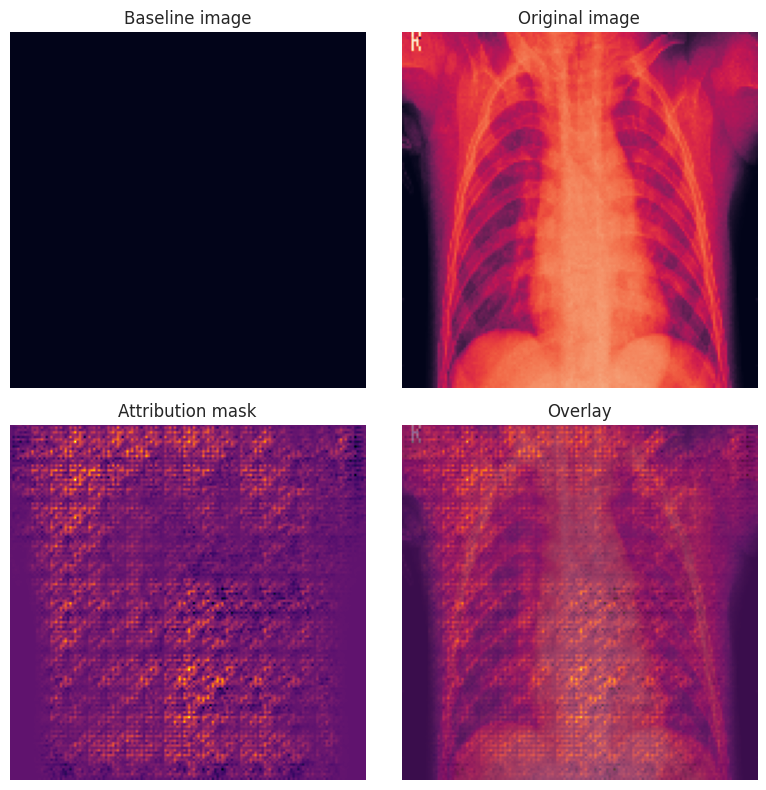

In [90]:
fig, attributions = plot_img_attributions(
		image=test[0][0],
		baseline=baseline,
		m_steps=5,
		cmap=plt.cm.inferno,
		overlay_alpha=0.4,
		target_is_class_zero=True,
		)

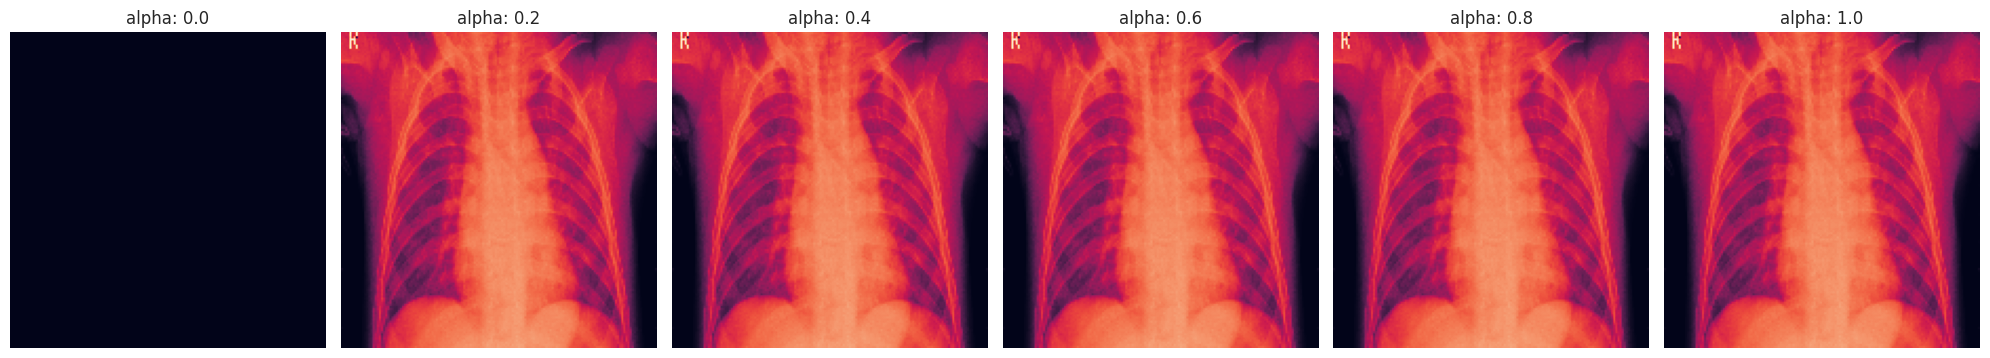

In [107]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(tf.reshape(image, [150,150]))
  plt.axis('off')

plt.tight_layout()

(0.0, 1.0)

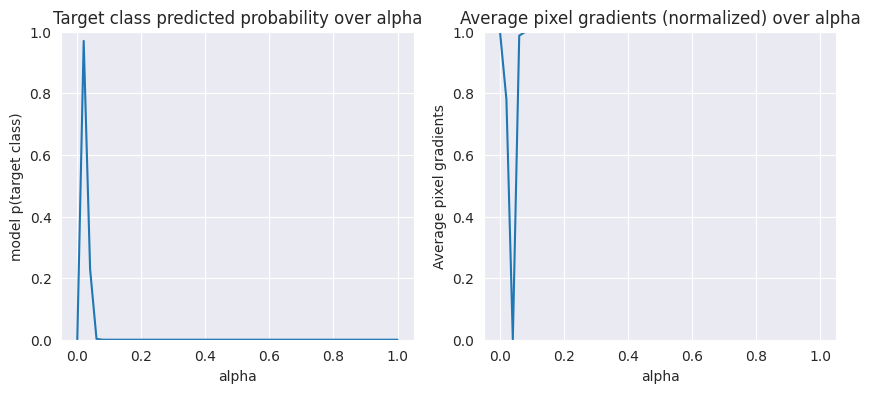

In [151]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.set_xlabel('alpha')
ax1.plot(alphas, pred)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g., (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1])

### 5 Healthy Cases

In [127]:
lala = test[0][0] == x_test[0].squeeze()
lala.shape

(150, 150)

In [132]:
pd.DataFrame(lala).value_counts()

0      1      2      3      4      5      6      7      8      9      10     11     12     13     14     15     16     17     18     19     20     21     22     23     24     25     26     27     28     29     30     31     32     33     34     35     36     37     38     39     40     41     42     43     44     45     46     47     48     49     50     51     52     53     54     55     56     57     58     59     60     61     62     63     64     65     66     67     68     69     70     71     72     73     74     75     76     77     78     79     80     81     82     83     84     85     86     87     88     89     90     91     92     93     94     95     96     97     98     99     100    101    102    103    104    105    106    107    108    109    110    111    112    113    114    115    116    117    118    119    120    121    122    123    124    125    126    127    128    129    130    131    132    133    134    135    136    137    138    139    140    141    142   

In [126]:
x_test[0].shape

(150, 150, 1)

In [125]:
test[0][0].shape

(150, 150)

In [123]:
you = np.ones([1,2,3])
you[0,1,2] = 2
you[0,0,1] = 3
you

array([[[1., 3., 1.],
        [1., 1., 2.]]])

In [ ]:
predictions_proba
predictions
y_test

In [108]:
correct = np.nonzero(predictions.flatten() == y_test)[0]
incorrect = np.nonzero(predictions.flatten() != y_test)[0]

In [110]:
incorrect.shape

(78,)

In [113]:
len(np.nonzero(predictions.flatten() == y_test))

1

In [111]:
correct.shape

(546,)

In [119]:
x_test[0]

array([[[0.51764706],
        [0.51764706],
        [0.54509804],
        ...,
        [0.2627451 ],
        [0.23137255],
        [0.19215686]],

       [[0.52941176],
        [0.51764706],
        [0.5254902 ],
        ...,
        [0.25882353],
        [0.25882353],
        [0.23529412]],

       [[0.54117647],
        [0.53333333],
        [0.49803922],
        ...,
        [0.39215686],
        [0.3254902 ],
        [0.26666667]],

       ...,

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]])

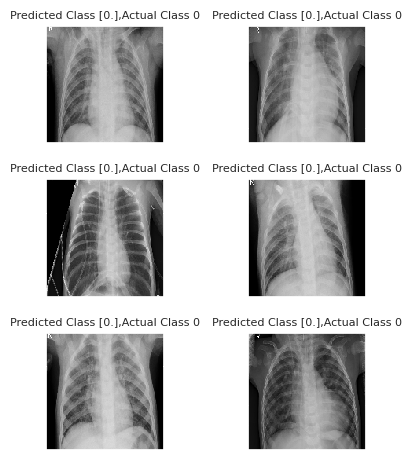

In [ ]:
i = 0
# TODO(pinolej): use fig, axs = plt.subplots(2, 2, figsize=(15, 15)) to increase figsize
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]), fontsize=8)
    plt.tight_layout()
    i += 1

In [104]:
predictions.shape

NameError: name 'predictions' is not defined

### 5 Unhealthy cases

# GRAD-Cam

Inspired from:

*  https://www.tensorflow.org/tutorials/interpretability/integrated_gradients

In [99]:
# load model
from keras import models
model = models.load_model('cnn_v0.h5')

In [93]:
# import the necessary packages
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
class GradCAM:
	def __init__(self, model, classIdx, layerName=None):
		# store the model, the class index used to measure the class
		# activation map, and the layer to be used when visualizing
		# the class activation map
		self.model = model
		self.classIdx = classIdx
		self.layerName = layerName
		# if the layer name is None, attempt to automatically find
		# the target output layer
		if self.layerName is None:
			self.layerName = self.find_target_layer()

	def find_target_layer(self):
		# attempt to find the final convolutional layer in the network
		# by looping over the layers of the network in reverse order
		for layer in reversed(self.model.layers):
			# check to see if the layer has a 4D output
			if len(layer.output_shape) == 4:
				return layer.name
		# otherwise, we could not find a 4D layer so the GradCAM
		# algorithm cannot be applied
		raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

	def compute_heatmap(self, image, eps=1e-8):
		# construct our gradient model by supplying (1) the inputs
		# to our pre-trained model, (2) the output of the (presumably)
		# final 4D layer in the network, and (3) the output of the
		# softmax activations from the model
		gradModel = Model(
			inputs=[self.model.inputs],
			outputs=[self.model.get_layer(self.layerName).output,
				self.model.output])
		# record operations for automatic differentiation
		with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
			inputs = tf.cast(image, tf.float32)
			(convOutputs, predictions) = gradModel(inputs)
			loss = predictions[:, self.classIdx]
		# use automatic differentiation to compute the gradients
		grads = tape.gradient(loss, convOutputs)

		# compute the guided gradients
		castConvOutputs = tf.cast(convOutputs > 0, "float32")
		castGrads = tf.cast(grads > 0, "float32")
		guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
		convOutputs = convOutputs[0]
		guidedGrads = guidedGrads[0]

		# compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
		weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
		cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

		# grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
		(w, h) = (image.shape[2], image.shape[1])
		heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
		numer = heatmap - np.min(heatmap)
		denom = (heatmap.max() - heatmap.min()) + eps
		heatmap = numer / denom
		heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
		return heatmap


	def overlay_heatmap(self, heatmap, image, alpha=0.5,
		colormap=cv2.COLORMAP_VIRIDIS):
		# apply the supplied color map to the heatmap and then
		# overlay the heatmap on the input image
		heatmap = cv2.applyColorMap(heatmap, colormap)
		output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
		# return a 2-tuple of the color mapped heatmap and the output,
		# overlaid image
		return (heatmap, output)

In [94]:
# import the necessary packages
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
import imutils
import cv2


In [95]:
# load the input image from disk (in Keras/TensorFlow format) and
# preprocess it
image = test[-10][0]
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
# image = tf.squeeze(image, [3])
# image = imagenet_utils.preprocess_input(image)

In [96]:
# use the network to make predictions on the input image and find
# the class label index with the largest corresponding probability
# preds = model(test[-1][0])
preds = model(image)
# i = np.argmax(preds[0])
# # decode the ImageNet predictions to obtain the human-readable label
# decoded = imagenet_utils.decode_predictions(preds)
# (imagenetID, label, prob) = decoded[0][0]
# label = "{}: {:.2f}%".format(label, prob * 100)
# print("[INFO] {}".format(label))

In [98]:
preds

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>

In [101]:
lala = model(tf.reshape(test[-10][0], [1, 150, 150, 1]))
lala

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>

In [102]:
lala = model(x_test[0:10,:,:,:])

In [103]:
lala

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[4.3380838e-02],
       [1.8149816e-05],
       [4.3501835e-02],
       [8.1064694e-02],
       [1.0837660e-01],
       [5.8836672e-03],
       [1.0402227e-02],
       [1.1596616e-08],
       [1.6184042e-03],
       [1.0244152e-06]], dtype=float32)>

# Appendix

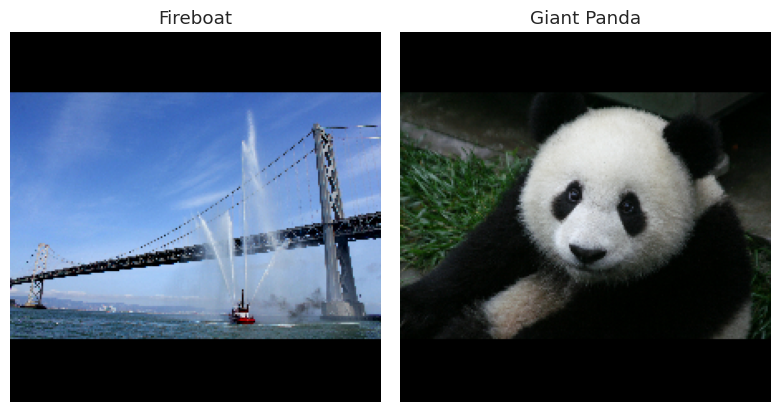

In [ ]:
plt.figure(figsize=(8, 8))
for n, (name, img_tensors) in enumerate(img_name_tensors.items()):
  ax = plt.subplot(1, 2, n+1)
  ax.imshow(img_tensors)
  ax.set_title(name)
  ax.axis('off')
plt.tight_layout()

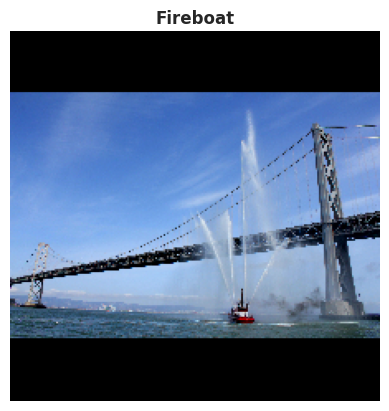

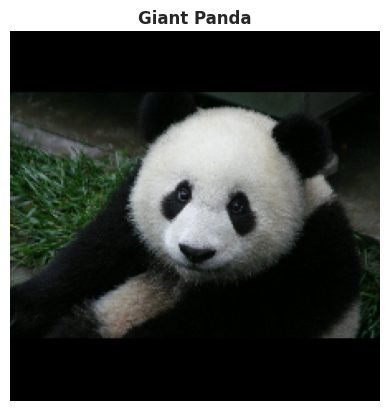

In [ ]:
for (name, img_tensor) in img_name_tensors.items():
  plt.imshow(img_tensor)
  plt.title(name, fontweight='bold')
  plt.axis('off')
  plt.show()

In [ ]:
# class Example(BaseClass):
#     """An example Parameterized class"""
#     timestamps = []

#     boolean                 = param.Boolean(True, doc="A sample Boolean parameter")
#     color                   = param.Color(default='#FFFFFF')
#     date                    = param.Date(dt.datetime(2017, 1, 1),
#                                          bounds=(dt.datetime(2017, 1, 1), dt.datetime(2017, 2, 1)))
#     select_string           = param.ObjectSelector(default="yellow",objects=["red","yellow","green"])
#     select_fn               = param.ObjectSelector(default=list,objects=[list,set,dict])
#     int_list                = param.ListSelector(default=[3,5], objects=[1,3,5,7,9],precedence=0.5)
#     single_file             = param.FileSelector(path='../../*/*.py*',precedence=0.5)
#     multiple_files          = param.MultiFileSelector(path='../../*/*.py?',precedence=0.5)
#     record_timestamp        = param.Action(lambda x: x.timestamps.append(dt.datetime.now()),
#                                            doc="""Record timestamp.""",precedence=0.7)

In [ ]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28 * 28 * 1, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 10)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)
  
  def compute_l1_loss(self, w):
      return torch.abs(w).sum()

# https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-l1-l2-and-elastic-net-regularization-with-pytorch.md

In [ ]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        be_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-be_loss)
        print('be loss is {}'.format(be_loss))
        print('pt is {}'.format(pt))
        loss = (self.alpha[targets] * (1 - pt) ** self.gamma * be_loss).mean()
        return loss